# Text Classification - IMDB

# Imports 

In [1]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Global vairiables for script

cross_validation_iterations = 30


# Exploring the Dataset

In [3]:
filename = 'movie_data_cat.csv'
IMDB_dataframe = pd.read_csv(filename, encoding='utf-8')

In [4]:
IMDB_dataframe.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",pos
1,OK... so... I really like Kris Kristofferson a...,neg
2,"***SPOILER*** Do not read this, if you think a...",neg
3,hi for all the people who have seen this wonde...,pos
4,"I recently bought the DVD, forgetting just how...",neg


# Converting Class Index to int

In [5]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(IMDB_dataframe['sentiment']))}

print(class_mapping)
class_labels = [x for x in class_mapping] # store the class labels for later

{'neg': 0, 'pos': 1}


In [6]:
#use the mapping dictionary to transform the class labels into integers

IMDB_dataframe["sentiment"] = IMDB_dataframe["sentiment"].map(class_mapping)


In [7]:
IMDB_dataframe.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


# Cleaning up the Data

In [8]:
IMDB_dataframe.loc[42, 'review']#[-50:]

'This is a big step down after the surprisingly enjoyable original. This sequel isn\'t nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best thing about this series, but his wisecracking is toned down in this entry. The performances are all adequate, but this time the script lets us down. The action is merely routine and the plot is only mildly interesting, so I need lots of silly laughs in order to stay entertained during a "Trancers" movie. Unfortunately, the laughs are few and far between, and so, this film is watchable at best.'

In [9]:
#import regular expressions to clean up the text
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

In [10]:
preprocessor(IMDB_dataframe.loc[42, 'review'])#[-50:]

'this is a big step down after the surprisingly enjoyable original this sequel isn t nearly as fun as part one and it instead spends too much time on plot development tim thomerson is still the best thing about this series but his wisecracking is toned down in this entry the performances are all adequate but this time the script lets us down the action is merely routine and the plot is only mildly interesting so i need lots of silly laughs in order to stay entertained during a trancers movie unfortunately the laughs are few and far between and so this film is watchable at best '

In [11]:
# apply the preprocessor to the entire dataframe (i.e. column review)
IMDB_dataframe['review'] = IMDB_dataframe['review'].apply(preprocessor)

# Tokenise, Stemmer & Stop

In [12]:
from nltk.corpus import stopwords 

nltk.download('stopwords')


stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def tokenizer(text):
    text = str(text)
    return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]


def stop_removal(text):
       return [w for w in text if not w in stop]
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
IMDB_dataframe.loc[42, 'review']

'this is a big step down after the surprisingly enjoyable original this sequel isn t nearly as fun as part one and it instead spends too much time on plot development tim thomerson is still the best thing about this series but his wisecracking is toned down in this entry the performances are all adequate but this time the script lets us down the action is merely routine and the plot is only mildly interesting so i need lots of silly laughs in order to stay entertained during a trancers movie unfortunately the laughs are few and far between and so this film is watchable at best '

In [14]:
# IMDB_dataframe_subset = IMDB_dataframe.sample(n=10000) #Uncomment and comment line bellow for faster processing.
IMDB_dataframe_subset = IMDB_dataframe

# Training for Sentiment Classification

In [15]:
X_val_train, X_test, y_val_train, y_test = train_test_split(
     IMDB_dataframe_subset.iloc[:,0], IMDB_dataframe_subset.iloc[:,1], test_size=0.20, random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
     X_val_train, y_val_train, test_size=0.10, random_state=42)

In [17]:
print("Number of entries for Training of best models: " + str(len(X_train)))
print("Number of entries for Validating best models: " + str(len(X_val)))
print("Number of entries for Testing best models: " + str(len(X_test)))

Number of entries for Training of best models: 36000
Number of entries for Validating best models: 4000
Number of entries for Testing best models: 10000


In [18]:
param_grid0 = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
               'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
               'vect__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
               ]

In [19]:
# LogisticRegression().get_params().keys()

param_grids = [
    # Logistical Regression Settings
    {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__C': range(1, 5, 1)
    },
    # MultinomialNB Settings
    {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__fit_prior': [True, False],
        'clf__alpha': range(1, 5, 1)
    },
    # SVC Settings
    {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__C': range(1, 5, 1),
        'clf__kernel': ['rbf', 'linear', 'sigmoid'],
        'clf__gamma': np.arange(0.0, 1.0, 0.1)
    },
    
]

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)


base_models = [LogisticRegression(),
                   MultinomialNB(class_prior = None),
                   SVC()]


# Quicker test settings
param_grids = [
    # Logistical Regression Settings
    {
        'vect__ngram_range': [(1, 1), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__C': range(2, 4, 1)
    },
    # MultinomialNB Settings
    {
        'vect__ngram_range': [(1, 1), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__fit_prior': [True, False],
        'clf__alpha': range(4, 6, 1)
    },
    # SVC Settings
    {
        'vect__ngram_range': [(1, 1), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__C': range(1, 3, 1),
        'clf__kernel': ['linear', 'sigmoid'],
        'clf__gamma': np.arange(0.6, 0.9, 0.1)
    },
    
]


my_models = []

def testModel(params, model):
    print("Testing: " + model.__class__.__name__)
    
    mnb_tfidf = Pipeline([('vect', tfidf),
                     ('clf',  model)])
                   
    gs_mnb_tfidf = GridSearchCV(mnb_tfidf, params,
                               scoring='accuracy',
                               cv=3, #change to `cross_validation_iterations` if you have lots of time!
                               verbose=1,
                               n_jobs=-1)
    
#     print(sorted(mnb_tfidf.get_params().keys()))
    
    gs_mnb_tfidf.fit(X_val, y_val)
    
         
    clf = gs_mnb_tfidf.best_estimator_
    
    print("Model cv score: " + str(gs_mnb_tfidf.best_score_* 100))
    
    return clf
  
    
    

for item in range(0, len(base_models)):
    best_model = testModel(param_grids[item], base_models[item]) 
    my_models.append((str(base_models[item].__class__.__name__), best_model))
                  
 
    
    
    
print('Best models created!')

Testing: LogisticRegression
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.0min finished


Model cv score: 86.35000000000001
Testing: MultinomialNB
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  9.1min finished


Model cv score: 85.85000000000001
Testing: SVC
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 57.2min finished


Model cv score: 87.35000000000001
Best models created!


In [49]:
print(my_models[0][1].get_params()['vect'])
print(my_models[1][1].get_params()['vect'])
print(my_models[2][1].get_params()['vect'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'whom', 'of', 'yourselves', 've', 'than', 'if', 'their', "don't", 'itself', 'an', 'both', 'with', 'do', 'above', 'that', 'any', 'by', 'doesn', 'nor', 'will', 'had', 'i', 'did', "it's", 'isn', "isn't", 'didn', "won't", 'this', 'very', "hasn't", 'won', 'into', 'where', 'own', 'they', 'duri...uldn't", "shouldn't", 'some', 'now', 'does', 'between', 'why', 'was', 'in', 'after', 'same', 'then'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_stemmer at 0x7f58283e6048>,
        use_idf=True, vocabulary=None)
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, e

### Settings found to be good
if you do not have time to test paramiters, settings bellow have found to be good:

Remove StopWords
```
LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
MultinomialNB(alpha=4, class_prior=None, fit_prior=False)
SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.8999999999999999,
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
  
```

In [22]:
results = []
names = []
roc_prediction = []
for name, model in my_models:
    print('---------------------------------')
    print('Cross validation of model: ' + name + ' with settings: \n')
    print(str(model.get_params()['clf']) + '\n')
    
    cv = ShuffleSplit(n_splits=cross_validation_iterations, test_size=0.2, random_state=42)
    
    cv_results = model_selection.cross_val_score(model, X_train, y_train, 
                                                 cv=cv, scoring='accuracy',
                                                 verbose=1,
                                                 n_jobs=-1)
    roc_prediction.append(model.predict(X_test))
    print(cv_results)
    results.append(cv_results)
    names.append(name)
    print('---------------------------------')
    print('Complete')
    

---------------------------------
Cross validation of model: LogisticRegression with settings: 

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 26.9min finished


[0.89458333 0.90013889 0.89583333 0.90027778 0.89125    0.89277778
 0.89319444 0.9        0.88958333 0.89388889 0.89541667 0.88777778
 0.89305556 0.89319444 0.89388889 0.895      0.89652778 0.89486111
 0.89236111 0.89597222 0.89291667 0.90055556 0.89666667 0.88652778
 0.89236111 0.89569444 0.90194444 0.88611111 0.90027778 0.88722222]
---------------------------------
Complete
---------------------------------
Cross validation of model: MultinomialNB with settings: 

MultinomialNB(alpha=4, class_prior=None, fit_prior=False)



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.3min finished


[0.88055556 0.88444444 0.88       0.88263889 0.87833333 0.87555556
 0.8875     0.88402778 0.88444444 0.8825     0.87972222 0.87777778
 0.88347222 0.88361111 0.88180556 0.88013889 0.88277778 0.87986111
 0.88222222 0.88236111 0.88486111 0.88305556 0.88083333 0.875
 0.87888889 0.88111111 0.88597222 0.87805556 0.88194444 0.87666667]
---------------------------------
Complete
---------------------------------
Cross validation of model: SVC with settings: 

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.8999999999999999,
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 535.6min finished


[0.91847222 0.92166667 0.91680556 0.91902778 0.91027778 0.91708333
 0.91930556 0.92152778 0.91458333 0.91708333 0.91861111 0.91486111
 0.91708333 0.91763889 0.91791667 0.91694444 0.91791667 0.91597222
 0.91902778 0.91986111 0.91986111 0.91888889 0.91902778 0.91361111
 0.91416667 0.92083333 0.92291667 0.91569444 0.91694444 0.91611111]
---------------------------------
Complete


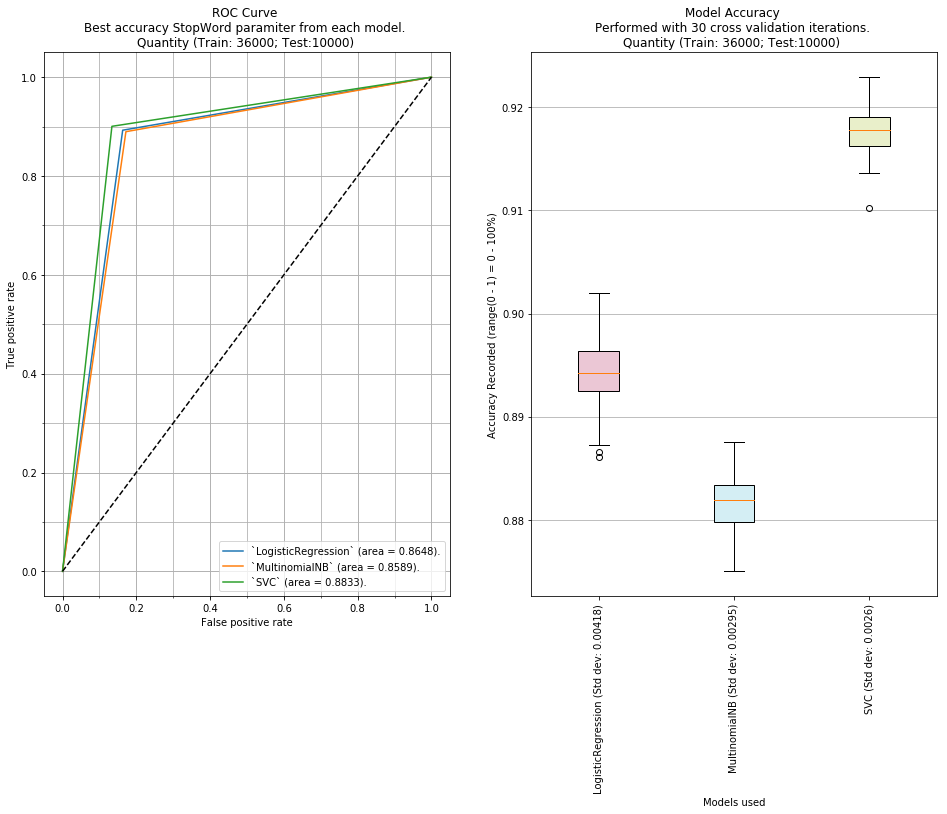

In [34]:
from matplotlib.ticker import MultipleLocator
from math import *
from statistics import *

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

for result in range(0, len(results)):
    fpr, tpr, threshold = roc_curve(y_test, roc_prediction[result]) 

# This is the AUC
    the_auc = auc(fpr, tpr)
# This is the ROC curve

    plot_label = "`" + names[result] + "` (area = "+str(round(the_auc, 4))+")."
    
    axes[0].plot(fpr,tpr, label=plot_label)

axes[0].plot([0, 1], [0, 1], 'k--') # diagonal    

axes[0].set_title('ROC Curve \n'+
                  'Best accuracy StopWord paramiter from each model. \n' +
                 'Quantity (Train: ' + str(X_train.count()) + '; Test:' + str(X_test.count())+') ')
axes[0].set_xlabel('False positive rate')
axes[0].set_ylabel('True positive rate')
axes[0].legend(loc='best')
axes[0].xaxis.grid(True)

spacing = 0.1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)

axes[0].yaxis.set_minor_locator(minorLocator)
axes[0].xaxis.set_minor_locator(minorLocator)
axes[0].grid(which = 'minor')


# box plot

sd_labels = []

for plot_name in range(0, len(results)):
    sd_labels.append(names[plot_name] + " (Std dev: " + str(round(results[plot_name].std(), 5)) + ")")

bplot2 = axes[1].boxplot(results,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=sd_labels
                         )  # will be used to label x-ticks
axes[1].set_title('Model Accuracy \n'+ 
                  'Performed with ' + str(cross_validation_iterations) +' cross validation iterations. \n' + 
                  'Quantity (Train: ' + str(X_train.count()) + '; Test:' + str(X_test.count())+') ')

axes[1].set_xlabel('Models used')
axes[1].set_ylabel('Accuracy Recorded (range(0 - 1) = 0 - 100%)')

# fill with colors
colors = ['#EBC7D5', '#D4EEF4', '#E9EFCA']
for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)

    
    
plt.xticks(rotation=90)
plt.show()

In [46]:
print("Mean values")
for result in range(0, len(results)):
    print(str(names[result])+ ": " +str(round(results[result].mean()*100,2)) + "%")

Mean values
LogisticRegression: 89.43%
MultinomialNB: 88.13%
SVC: 91.77%


In [47]:
print("Max values")
for result in range(0, len(results)):
    print(str(names[result])+ ": " +str(round(results[result].max()*100,2)) + "%")

Max values
LogisticRegression: 90.19%
MultinomialNB: 88.75%
SVC: 92.29%


In [48]:
print("Standard Deviation")
for result in range(0, len(results)):
    print(str(names[result])+ ": " +str(round(results[result].std()*100,2)) + "%")

Standard Deviation
LogisticRegression: 0.42%
MultinomialNB: 0.3%
SVC: 0.26%
